In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('C:\\Users\\Shashvat Singhal\\Desktop\\youse ai\\Data\\Data\\Dataset.csv')
print(df.head())
print(df.isnull().sum())
print(df.dtypes)

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

In [3]:
print(df.describe())

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

### There are null values present in our dataset, in the columns 'Minimum_payments" & "payments" for which SimpleImputer was used along the mean value of the columns

### Also CUST_ID is a non-numerical column so we drop that

In [4]:

# CUST_ID is a string, the rest are numerical columns
# Drop CUST_ID as it's non-numerical and not required for clustering and preprocessing
df.drop(columns=['CUST_ID'], inplace=True)

# Step 1: Handling Missing Values
# Use SimpleImputer to fill missing values (mean for numerical values)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Step 2: Feature Scaling
# Scale the data using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)


print(df_scaled.head())
print(df_scaled.isnull().sum())

    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451      

##### Along with Imputation and non numerical value dropping, Standard scaler was used to scales all the features. During Experimentation it was observed that without scaling PCA-based clustering didn't work well and the clusters formed were not good enough. 
##### This might be due to some features overpowering the others during dimentionality reduction, leading to improper cluster formation in the later stages

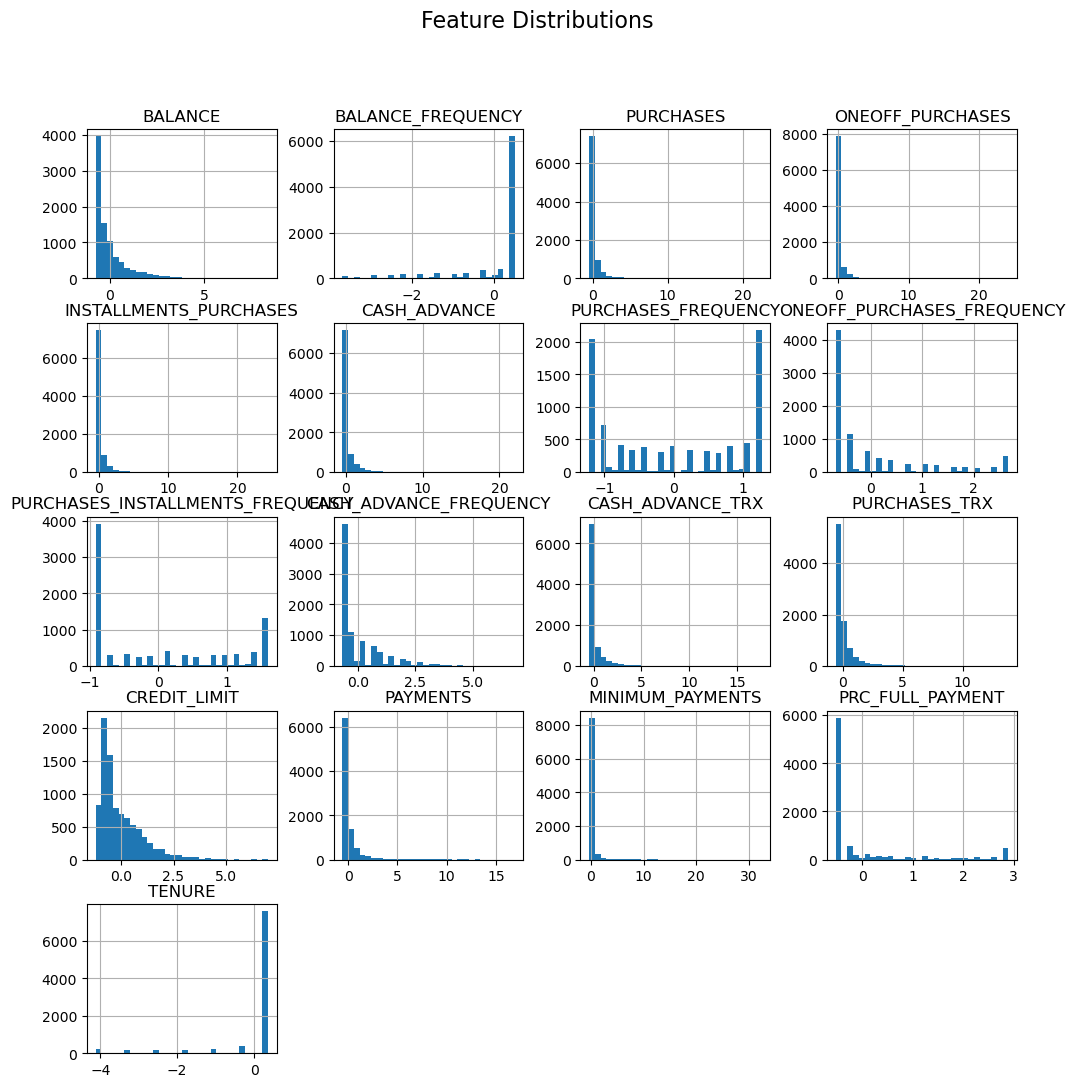

In [5]:
# Data Distribution via Histograms
df_scaled.hist(figsize=(12, 12), bins=30)
plt.suptitle('Feature Distributions', size=16)
plt.show()


###### Low Balance Majority: Most customers have low balances.
###### Low Cash Advance Use: Very few use cash advances.
###### Low Payment Frequency: Many customers make infrequent payments.
###### Varied Credit Limits: Majority have lower credit limits.
###### Short Tenure: Many newer accounts.

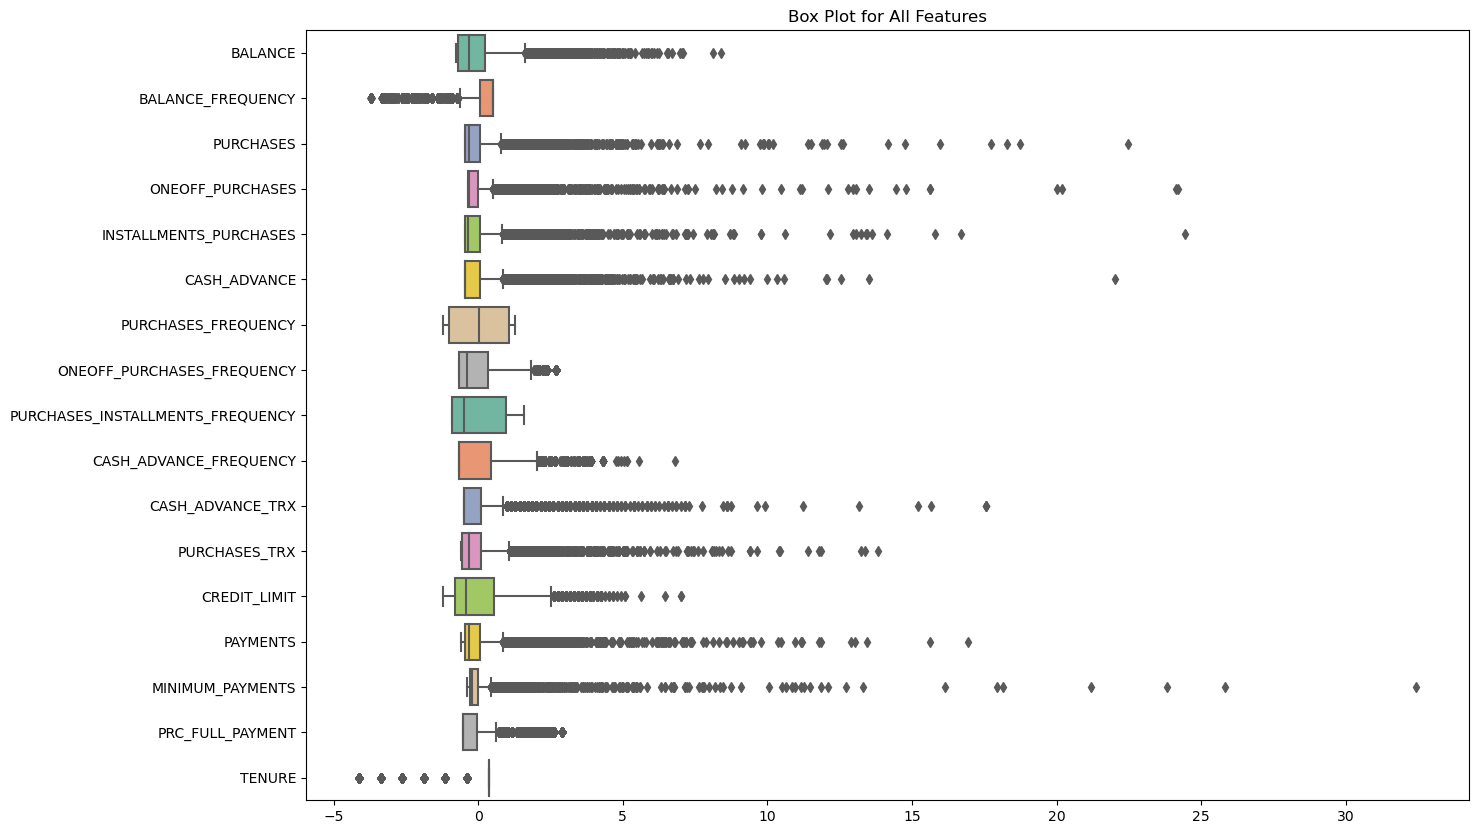

In [6]:
# Box plot for each feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_scaled, orient='h', palette='Set2')
plt.title('Box Plot for All Features')
plt.show()


###### Outliers: Most features have significant outliers, particularly in purchases, balance, and cash advances, indicating high variability and extreme cases.
###### Skewness: Many features are right-skewed (e.g., Balance, Credit Limit, Payments), showing that most customers have lower values with a few high-value exceptions.
###### Spread: Wide range in Installment Purchases, Purchases Frequency, and Cash Advances, suggesting diverse customer behaviors.
###### Tight Clusters: Features like PRC Full Payment and One-off Purchases Frequency show low variability, indicating uniformity across customers for these behaviors.

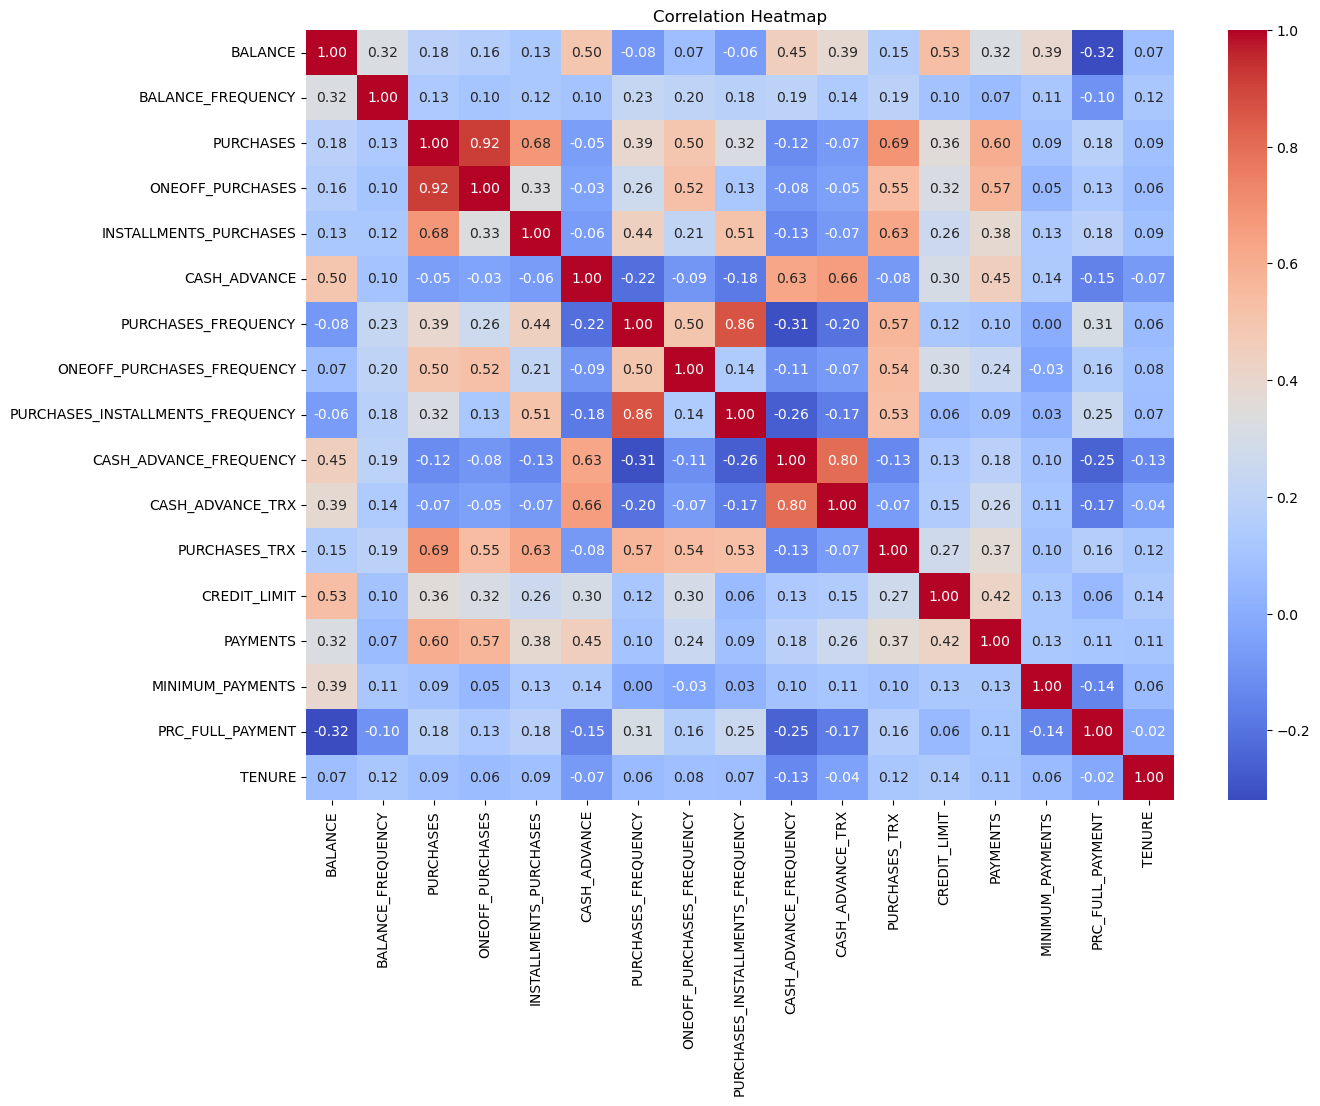

In [7]:
# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


###### High Correlation:Purchases highly correlate with One-off Purchases (0.92) and Installment Purchases (0.68), suggesting customers who make one type of purchase often engage in both.

###### Cash Advance Frequency is strongly related to Cash Advance Transactions (0.80), indicating frequent users of cash advances tend to make multiple transactions.

###### Balance & Credit Limit: Balance correlates with Credit Limit (0.53), showing that higher balances are often linked to higher credit limits.

###### Full Payment: PRC Full Payment negatively correlates with Balance (-0.32) and Cash Advance (-0.25), suggesting customers who pay off their balance fully tend to have lower balances and use fewer cash advances.

###### Distinct Clusters: Purchases and Installments are tightly grouped, while Cash Advances form a separate behavioral cluster.

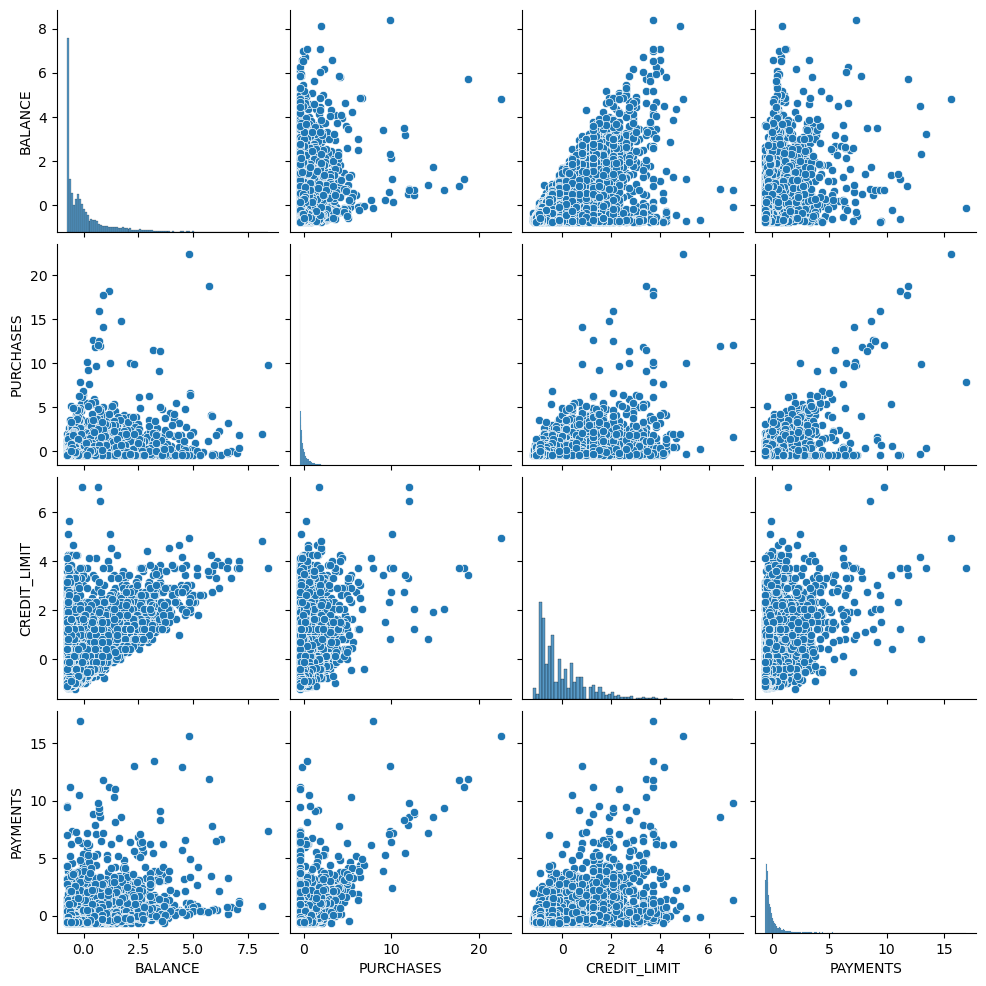

In [8]:
# Pairplot of selected features to visualize relationships
sns.pairplot(df_scaled[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']])
plt.show()


##### Balance vs Credit Limit: Positive correlation: Higher balances are associated with higher credit limits, though there are some customers with high credit limits but low balances.
##### Purchases vs Payments: Positive trend: Higher purchases correspond to higher payments, indicating that customers who spend more also tend to make larger payments.
##### Balance vs Purchases: Positive relationship: Higher credit limits are linked to higher payments, likely indicating better financial standing or higher spending capacity.

-----
# Clustering

### Elbow Method to find optimal number of clusters

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\clust

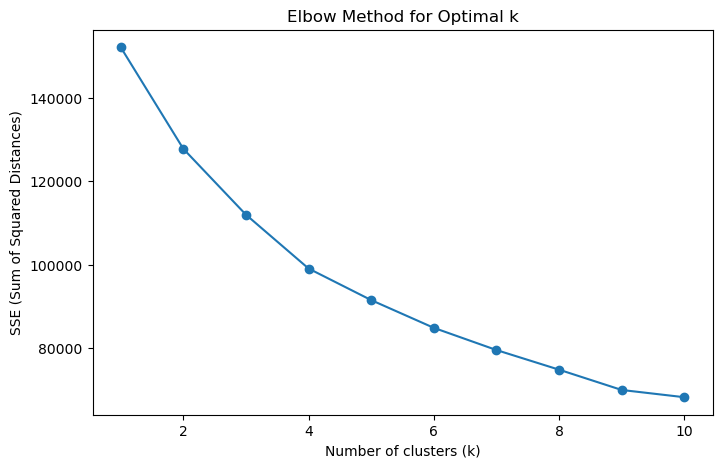

In [9]:
sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.show()


### Fitting KMeans, DBSCAN, Agglomerative Clustering Algorithms

In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Clustering Algorithms
kmeans = KMeans(n_clusters=4, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)
agglo = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

# K-Means Clustering
df_scaled['Cluster_KMeans'] = kmeans.fit_predict(df_scaled.drop(columns=['Cluster_DBSCAN', 'Cluster_Agglomerative'], errors='ignore'))

# Silhouette Score for K-Means
silhouette_kmeans = silhouette_score(df_scaled.drop(columns=['Cluster_KMeans']), df_scaled['Cluster_KMeans'])
print(f'Silhouette Score for K-Means: {silhouette_kmeans}')

# DBSCAN Clustering
df_scaled['Cluster_DBSCAN'] = dbscan.fit_predict(df_scaled.drop(columns=['Cluster_KMeans', 'Cluster_Agglomerative'], errors='ignore'))

# Silhouette Score for DBSCAN
dbscan_labels = df_scaled['Cluster_DBSCAN']
if len(set(dbscan_labels)) > 1:  # Avoid calculating silhouette score if only one cluster
    # Exclude noise points labeled as -1 from silhouette score calculation
    dbscan_non_noise = df_scaled['Cluster_DBSCAN'] != -1
    silhouette_dbscan = silhouette_score(df_scaled.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Agglomerative'], errors='ignore')[dbscan_non_noise], dbscan_labels[dbscan_non_noise])
    print(f'Silhouette Score for DBSCAN: {silhouette_dbscan}')
else:
    print("DBSCAN did not form multiple clusters.")

# Agglomerative Clustering
df_scaled['Cluster_Agglomerative'] = agglo.fit_predict(df_scaled.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN'], errors='ignore'))

# Silhouette Score for Agglomerative Clustering
silhouette_agglo = silhouette_score(df_scaled.drop(columns=['Cluster_Agglomerative', 'Cluster_KMeans', 'Cluster_DBSCAN'], errors='ignore'), df_scaled['Cluster_Agglomerative'])
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for K-Means: 0.1976074492720698
Silhouette Score for DBSCAN: -0.2882234502919882


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for Agglomerative Clustering: 0.1547093352037027


### Cluster Visualization using PCA

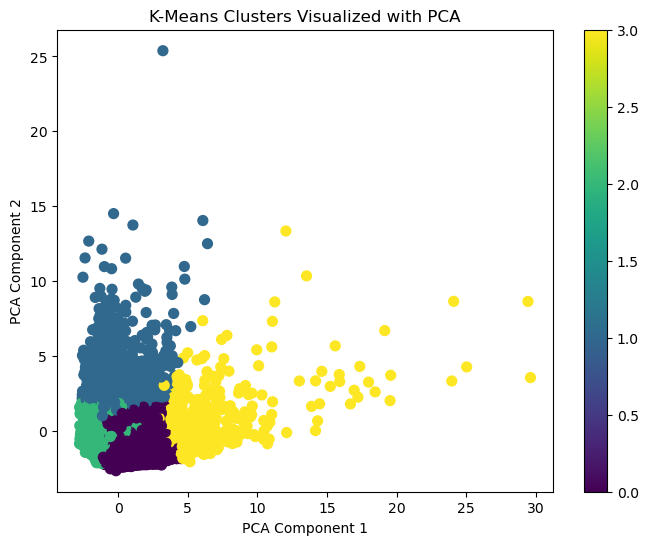

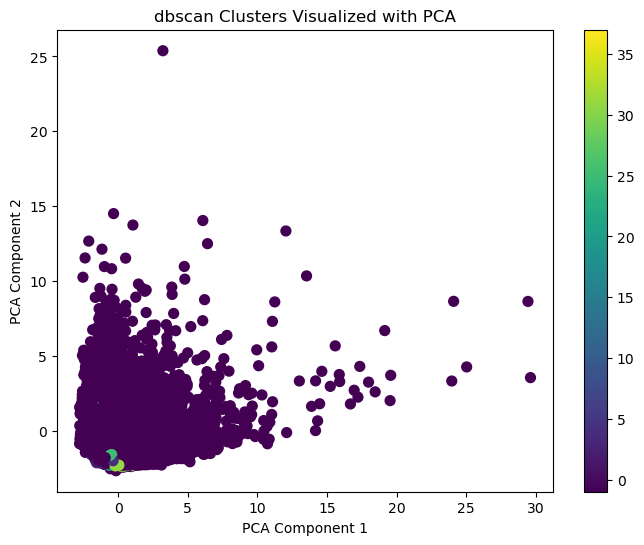

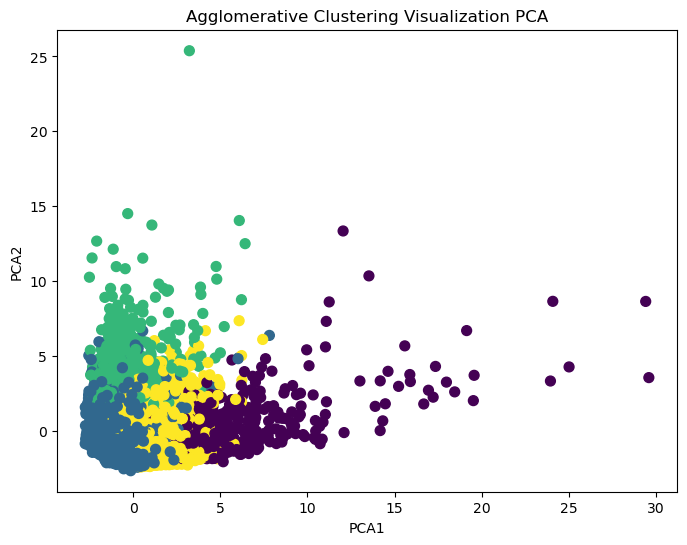

In [14]:

# Step 1: Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN','Cluster_Agglomerative'], axis=1))


plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_scaled['Cluster_KMeans'], cmap='viridis', s=50)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_scaled['Cluster_DBSCAN'], cmap='viridis', s=50)
plt.title('dbscan Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_scaled['Cluster_Agglomerative'], cmap='viridis', s=50)
plt.title('Agglomerative Clustering Visualization PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


### Cluster Visualization using t-SNE

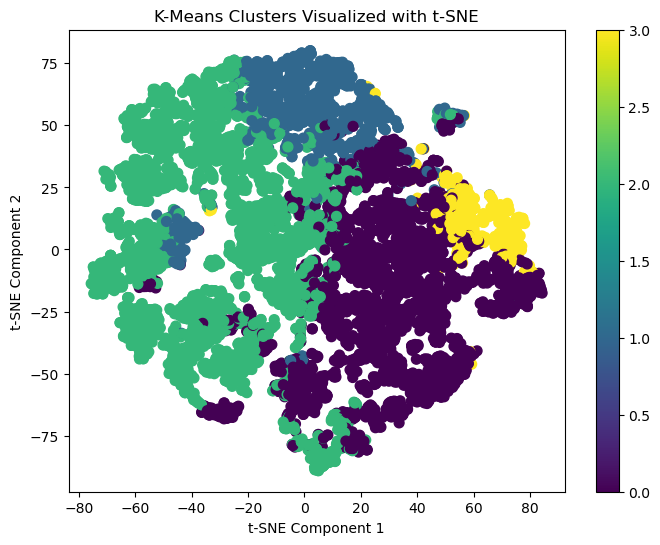

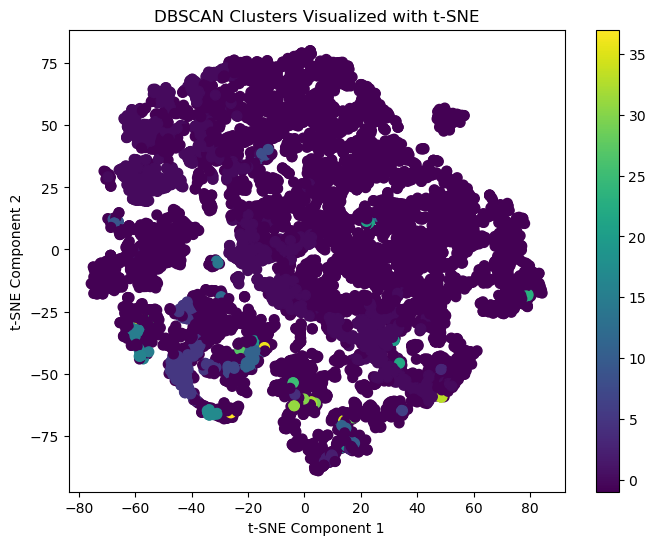

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


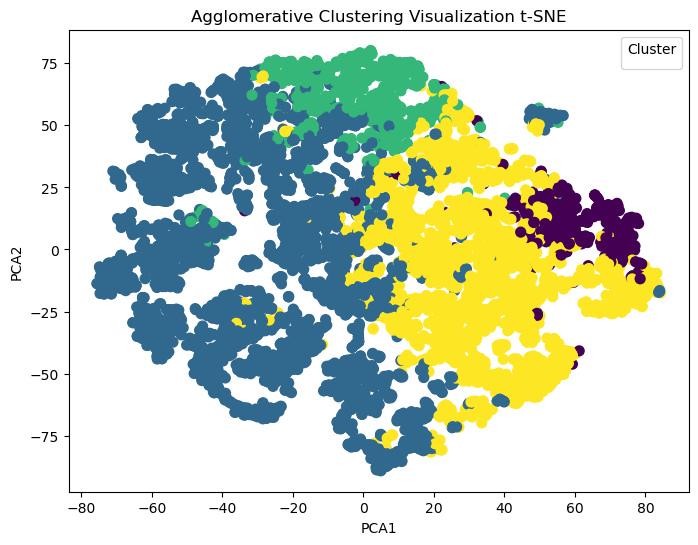

In [12]:


# Step 1: Apply t-SNE to reduce data to 2 dimensions (since t-SNE is mostly used for 2D/3D visualization)
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN','Cluster_Agglomerative'], axis=1))


plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_scaled['Cluster_KMeans'], cmap='viridis', s=50)
plt.title('K-Means Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_scaled['Cluster_DBSCAN'], cmap='viridis', s=50)
plt.title('DBSCAN Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_scaled['Cluster_Agglomerative'], cmap='viridis', s=50)
plt.title('Agglomerative Clustering Visualization t-SNE')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [13]:
# Step 1: Assign clusters from K-Means 
df['Cluster_KMeans'] = df_scaled['Cluster_KMeans']

# Step 2: Aggregate the data by clusters
cluster_profile = df.groupby('Cluster_KMeans').mean()

# Step 3: Display the cluster profile
print("Cluster Profiles based on K-Means Clustering:")
print(cluster_profile)

Cluster Profiles based on K-Means Clustering:
                    BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster_KMeans                                                                  
0                894.907458           0.934734  1236.178934        593.974874   
1               4602.462714           0.968415   501.896219        320.373681   
2               1011.751528           0.789871   269.973466        209.853863   
3               3551.153761           0.986879  7681.620098       5095.878826   

                INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster_KMeans                                                              
0                           642.478274    210.570626             0.885165   
1                           181.607404   4520.724309             0.287731   
2                            60.386625    595.759339             0.170146   
3                          2587.208264    653.638891             0.946418   

    

# Customer Profiling Based on K-Means Clustering

### Cluster 0:
- **Balance**: $894.91 (Medium)
- **Purchases**: $1236.18 (Moderate)
- **Installments**: $642.48 (Moderate)
- **Cash Advance**: $210.57 (Low)
- **Purchase Frequency**: 0.89 (High)
- **Credit Limit**: $4213.21 (Medium)
- **Payments**: $1332.19 (Moderate payments)
- **Minimum Payments**: $646.02 (Medium)
- **PRC Full Payment**: 26.9% (Moderate full balance payers)
- **Tenure**: 11.59 years
- **Customer Characteristics**:  
  Average spenders who balance between one-off and installment purchases. They have medium credit limits and payments but low cash advance usage.
  
- **Marketing Strategy**:  
  Encourage more one-off purchases by offering limited-time discounts. Provide higher-value rewards for full balance payers to increase engagement in full balance payments.

---

### Cluster 1:
- **Balance**: $4602.46 (High)
- **Purchases**: $501.90 (Low)
- **Installments**: $181.61 (Low)
- **Cash Advance**: $4520.72 (Very High)
- **Purchase Frequency**: 0.29 (Low)
- **Credit Limit**: $7546.96 (High)
- **Payments**: $3481.15 (High payments)
- **Minimum Payments**: $2020.80 (Very High)
- **PRC Full Payment**: 3.5% (Very low full balance payers)
- **Tenure**: 11.39 years
- **Customer Characteristics**:  
  Customers in this group have high balances, frequently use cash advances, and make large payments but tend to carry balances over time.
  
- **Marketing Strategy**:  
  Offer debt consolidation options or balance transfer promotions to reduce reliance on cash advances. Target these customers with financial advisory services to manage debt more effectively.

---

### Cluster 2:
- **Balance**: $1011.75 (Low)
- **Purchases**: $269.97 (Very Low)
- **Installments**: $60.39 (Minimal)
- **Cash Advance**: $595.76 (Moderate)
- **Purchase Frequency**: 0.17 (Low)
- **Credit Limit**: $3277.40 (Low)
- **Payments**: $974.51 (Moderate payments)
- **Minimum Payments**: $569.00 (Low)
- **PRC Full Payment**: 7.8% (Low full balance payers)
- **Tenure**: 11.45 years
- **Customer Characteristics**:  
  Low spenders with minimal engagement in both purchases and cash advances. Low frequency of transactions, both one-off and installments. They have a low credit limit and make relatively small payments.
  
- **Marketing Strategy**:  
  Promote installment-based purchases with offers to increase engagement. Use incentives like small rewards or cashback for increasing spending frequency.

---

### Cluster 3:
- **Balance**: $3551.15 (High)
- **Purchases**: $7681.62 (Very High)
- **Installments**: $2587.21 (High)
- **Cash Advance**: $653.64 (Moderate)
- **Purchase Frequency**: 0.95 (Very High)
- **Credit Limit**: $9696.94 (Very High)
- **Payments**: $7288.74 (Very High payments)
- **Minimum Payments**: $1985.04 (High)
- **PRC Full Payment**: 28.7% (Medium full balance payers)
- **Tenure**: 11.95 years
- **Customer Characteristics**:  
  High spenders with a strong focus on one-off and installment purchases. They have high credit limits and make large payments, with a good likelihood of paying off balances in full.
  
- **Marketing Strategy**:  
  Target with premium credit card offers, cashback, and loyalty programs. Provide exclusive rewards for maintaining high spending and timely payments.
